Acknowledgment This notebook is based on the "California Housing" case study by Aurélien Géron. I am grateful for his ability to make complex mathematical concepts (like Stratified Sampling and Pipelines) accessible and relevant for engineering applications.

# Importing the Data


In [1]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
%load_ext autoreload
%autoreload 2
import sys
import os


# Get the current folder path and go up one level ('..') to the project root
project_root = os.path.abspath('..')

# Add the root to the system path so Python can find 'src'
if project_root not in sys.path:
    sys.path.append(project_root)
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import warnings

def load_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        #Url
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path=("datasets"))
    return pd.read_csv(Path("datasets/housing/housing.csv"))
housing = load_data()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Note: Total bedrooms are less than others and missing values , will fix that later using imputer

# Function to Save FIGS ;)

In [5]:
IMAGES_ROOT_DIR = Path() / "images" / "housing_project_figures"
IMAGES_ROOT_DIR.mkdir(parents=True, exist_ok=True) #if not exist

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """" SAVES THE PLOTS TO THE DIRECTORY """
    try:
        path = IMAGES_ROOT_DIR / f"{fig_id}.{fig_extension}"
        if tight_layout:
            plt.tight_layout()
        plt.savefig(path, format=fig_extension, dpi=resolution)
        print(f"Successfully saved plot to {path}")
    except Exception as e:
        warnings.warn(f"Error saving plot '{fig_id}': {e}")

# Getting Started with EDA(Exploratory Data Analysis)

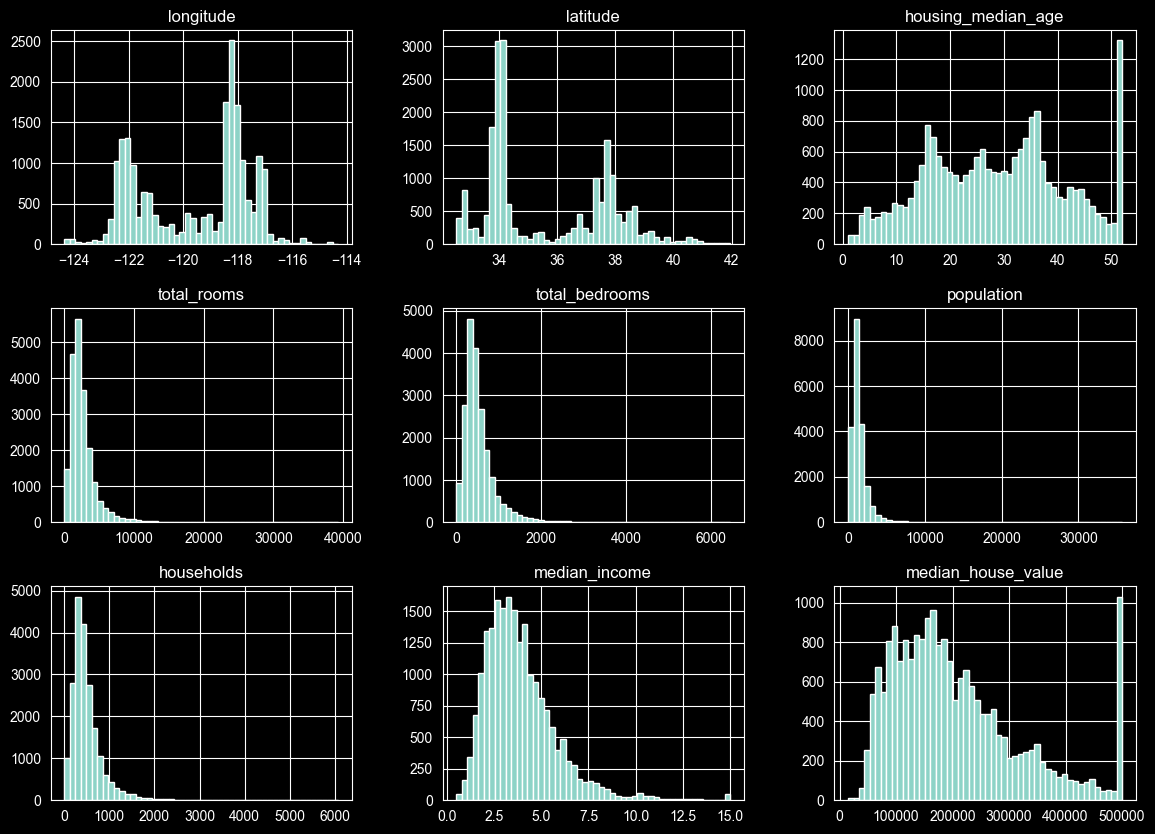

Successfully saved plot to images/housing_project_figures/housing_hist.png


<Figure size 640x480 with 0 Axes>

In [6]:
housing.hist(bins=50, figsize=(14,10), grid=True)
plt.show()
save_fig("housing_hist")

Here , we. can see various attributes that might afftect the pricing of the house , it might be dependednt on location , income , size or population desnity , but we need to find and chosse the best features and find the correlation between them

# Splitting The Dataset into Training and Test

In [7]:
from sklearn.model_selection import train_test_split
train_set ,test_set = train_test_split(housing, test_size=0.2, random_state=42)

after splitting the dataset , we find median income of house would be the one that might affect the housing prices so , since they are skewed in dataset as shown by graph most of the income lies to left side , so first we  convert into buckets

In [8]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6.0,np.inf], labels=[1,2,3,4,5])

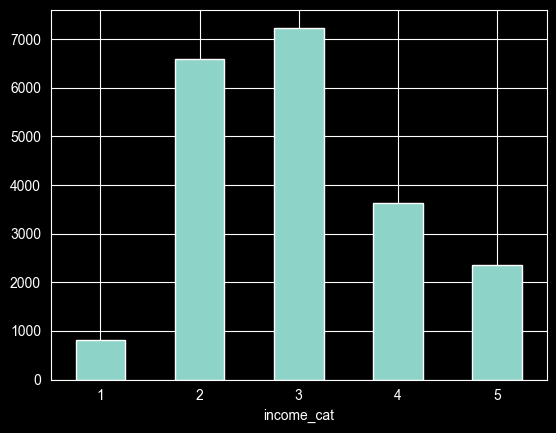

Successfully saved plot to images/housing_project_figures/housing_cat_income.png


<Figure size 640x480 with 0 Axes>

In [9]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.show()
save_fig("housing_cat_income")

now we can see when it's converted into Categories and would be beneficial for our model. but there is a better way to do that using stratified split

In [10]:
#the hard way
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n,strat_test_set_n])

In [11]:
strat_train_set, strat_test_set =strat_splits[0]

In [12]:
#the easy way
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [13]:
#verification
strat_test_set["income_cat"].value_counts() /len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

lets see the Difference b/w Random and strat data


In [14]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() /len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare = pd.DataFrame({
    "Overall %" : income_cat_proportions(housing),
    "Stratified %" : income_cat_proportions(strat_test_set),
    "Random %" : income_cat_proportions(test_set),
}).sort_index()

compare.index.name = "Income Categories"
compare["Strat. Error %"] = (compare["Stratified %"]/compare["Overall %"] - 1 )
compare["Random Error %"] = (compare["Random %"] / compare["Overall %"] - 1)

(compare*100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Random Error %
Income Categories,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


hence , the normal train test split skews the dataset and the error range is more with it , but with stratified it support better .
we can drop the income cat column now we dont need it anymore


In [15]:
#drop income_cat from both the sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# EDA

In [16]:
housing = strat_train_set.copy()

In [17]:
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


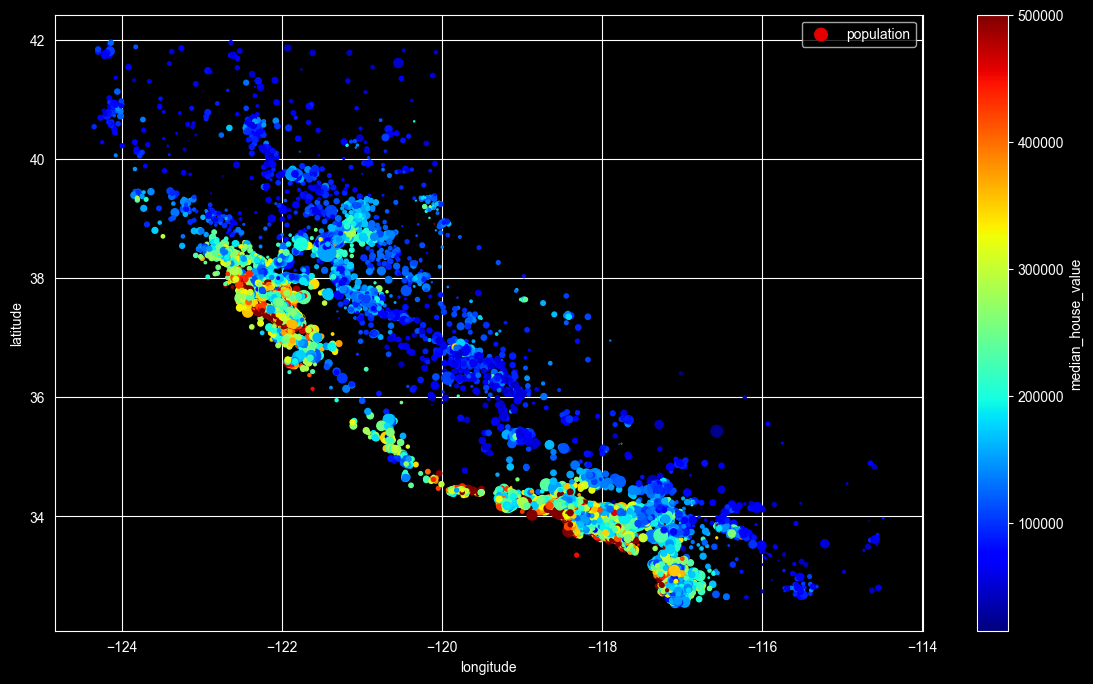

Successfully saved plot to images/housing_project_figures/geo_plot.png


<Figure size 640x480 with 0 Axes>

In [18]:
housing.plot(kind = "scatter" ,x="longitude", y="latitude",
            s= housing["population"]/100, label= "population",
            c="median_house_value",
            cmap="jet", colorbar=True,
            legend=True, sharex=False, grid =True, figsize=(14,8))
plt.show()
save_fig("geo_plot")

we can see the coastal area houses are more expensive but their are some exceptions

# Finding Correlations


In [19]:
corr_matrix = housing.corr(numeric_only=True)

In [20]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

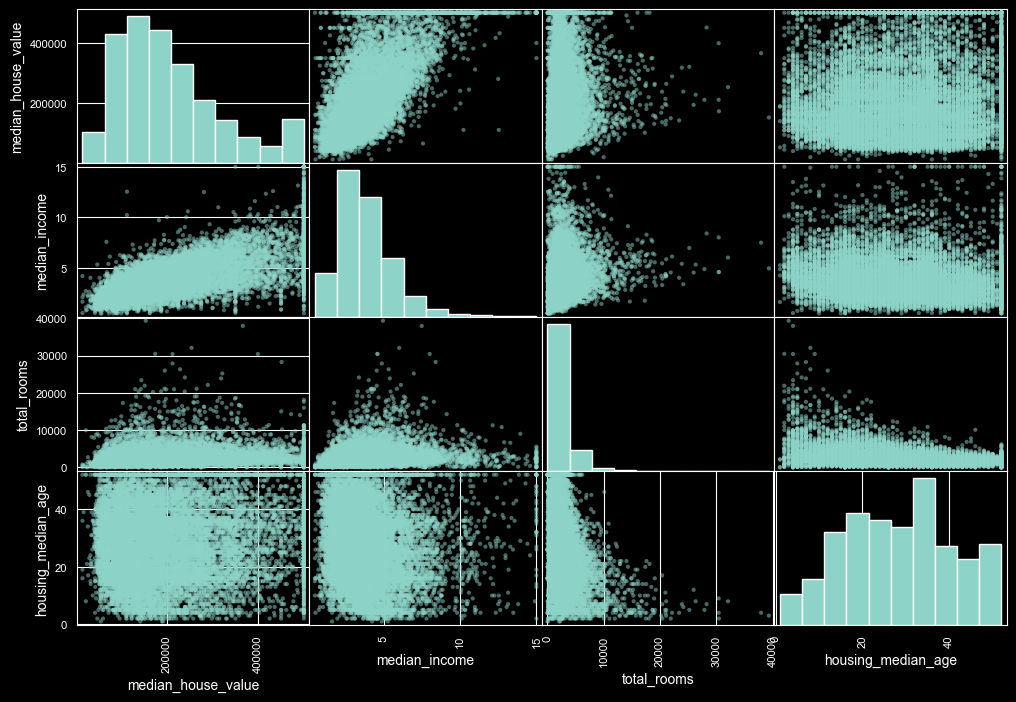

Successfully saved plot to images/housing_project_figures/scatterplot_corr.png


<Figure size 640x480 with 0 Axes>

In [21]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income",
               "total_rooms", "housing_median_age",]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()
save_fig("scatterplot_corr")

Successfully saved plot to images/housing_project_figures/scatterplot_median_income_vs_median_house_value.png


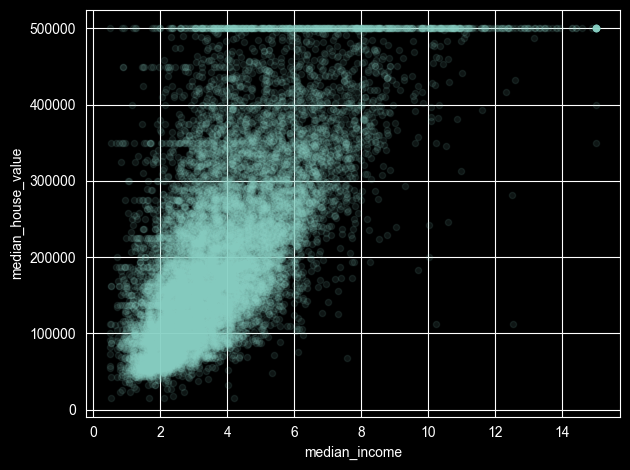

In [22]:
#lets focus on median_income since its one of the most reliable
housing.plot(kind="scatter", x = "median_income", y="median_house_value",alpha=0.1, grid=True )
save_fig("scatterplot_median_income_vs_median_house_value")
plt.show()

# Feature Engineering

In [23]:
housing["rooms_per_house"] = housing["total_rooms"]/ housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/ housing["total_rooms"]
housing["people_per_house"] = housing["population"]/ housing["households"]

In [24]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

median_income         , rooms_per_house       , total_rooms     most reliable factors      

# Prepare the Data

In [25]:
from sklearn import set_config
set_config(display='diagram')

In [26]:
# This is 'X' (The Features)
# the target without answers
housing = strat_train_set.drop("median_house_value", axis = 1)

# This is 'y' (The Labels)
# separate list of answers
housing_labels = strat_train_set["median_house_value"].copy()

In [27]:
#cleaning the data, we already knew the total_bedrooms column has unlisted values or empty rows
#we can either remove this column, which can damage the dataset, or we can fill the values

from src.preprocessing import imputer

In [28]:
housing_num = housing.select_dtypes(include=(np.number))
#choosing only numeric values coz we cant apply imputer on oceans_proximity which is object or text column

In [29]:
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [30]:
imputer.statistics_
#imputer.set_output(transform="pandas") #new version of scikit
#or
# set_config(transform_output="pandas")  # scikit-learn >= 1.2

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [31]:
#manual verification
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Transforming housing_num

In [32]:
X = imputer.transform(housing_num)

In [33]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

since we did Scikit operation on the X , its converted into Numpy array we need to convert it back to PD format

In [34]:
housing_tr = pd.DataFrame(X, 
                          columns=housing_num.columns, 
                          index=housing_num.index)

In [35]:
null_rows_idx = housing[housing.isnull().any(axis=1)].index
housing_tr.loc[null_rows_idx].head()
#filled with median values

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


# Converting Text Values to Numerical Values
since its easier for the Machines to understand Binary

In [36]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [37]:
from src.preprocessing import ordinal_encoder
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [38]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [39]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [40]:
from src.preprocessing import cat_encoder
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)


In [41]:
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [42]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# One Hot Encoder vs getdummies() Pandas

In [43]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND","NEAR OCEAN"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR OCEAN
0,True,False
1,False,True


In [44]:
cat_encoder.transform((df_test))

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [45]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies((df_test_unknown))

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [46]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [47]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [48]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [49]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [50]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


# Feature Scaling

In [51]:
#Normalisation
from src.preprocessing import min_max_scaler
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [52]:
#Standardization
from src.preprocessing import std_scaler
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

Successfully saved plot to images/housing_project_figures/long_tail_plot.png


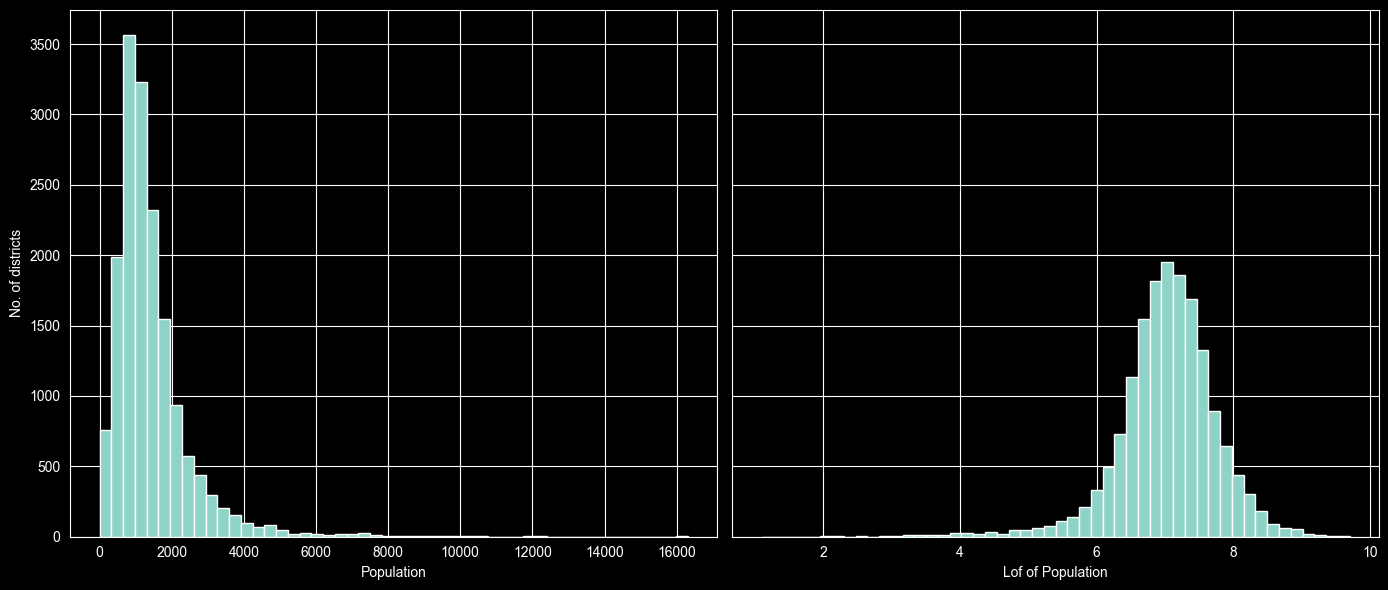

In [53]:
# Normal Population Vs Log of Population

fig, axs = plt.subplots(1,2, figsize=(14,6), sharey=True)
housing["population"].hist(ax=axs[0], bins = 50)
housing["population"].apply(np.log).hist(ax=axs[1], bins = 50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Lof of Population")
axs[0].set_ylabel("No. of districts")
save_fig("long_tail_plot")
plt.show()

In [54]:
from sklearn.metrics.pairwise import  rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.1)
#using double square brackets because index is required too

Successfully saved plot to images/housing_project_figures/age_similarity_plot_35.png


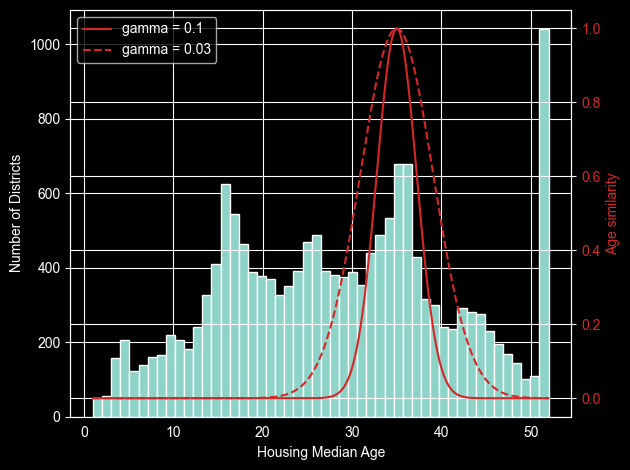

In [55]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1,1)

gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages,[[35]],gamma1)
rbf2 = rbf_kernel(ages,[[35]],gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing Median Age")
ax1.set_ylabel("Number of Districts")
ax1.hist(housing["housing_median_age"], bins = 50)

color = "tab:red"
ax2 = ax1.twinx()
ax2.plot(ages, rbf1, color=color ,label="gamma = 0.1")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot_35")
plt.show()

# Test Model

In [56]:
# 1st method
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame()) # because we also need to do for labels

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
#since the predict method gives the value in log we need to convert back to orignal scale via #exponent , this can be done with inverse_transform method
predictions = target_scaler.inverse_transform(scaled_predictions)

In [57]:
print(predictions)

[[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]


In [58]:
# 2nd method easy and shorter
from sklearn.compose import  TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
print(predictions)

[131997.15275877 299359.35844434 146023.37185694 138840.33653057
 192016.61557639]


# Custom Transformers

In [59]:
from src.preprocessing import log_transformer #function transformer
log_pop = log_transformer.transform(housing[["population"]])

In [60]:
from src.preprocessing import rbf_transformer #function transformer
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [61]:
#san Francisco coordinates Gaussian RBF
from sklearn.preprocessing import FunctionTransformer
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
#sf_simil

In [62]:
from src.preprocessing import ratio_transformer
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [63]:
from src.preprocessing import ClusterSimilarity

cluster_simil = ClusterSimilarity(n_clusters=10 , gamma=1, random_state=42)
# n clusters with the longitude and latitude weighting each district with its median house values
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight = housing_labels)

In [64]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

Successfully saved plot to images/housing_project_figures/district_cluster_plot.png


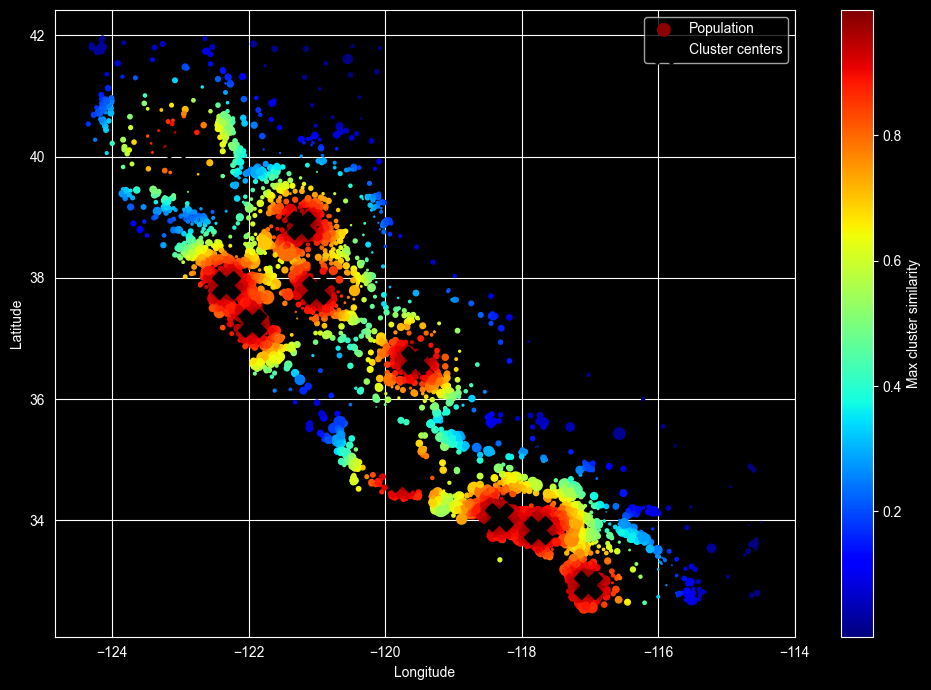

In [65]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

# Transformation Pipelines

In [66]:
from src.pipeline import num_pipeline

housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:3].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17],
       [-1.2 ,  1.28,  0.35, -0.71, -0.76, -0.79, -0.78, -0.76]])

In [67]:
# converting back to dataframe using get_features_out

df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index
)
#df_housing_num_prepared

In [68]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [69]:
#use double "_" to pass to hyperparameter
num_pipeline.set_params(simpleimputer__strategy = "median")

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [70]:
#1st method a bit longer to apply with ColumnTransformer
from src.pipeline import cat_pipeline
from sklearn.compose import ColumnTransformer
num_attributes = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attributes = ["ocean_proximity"]

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes),
])


In [71]:
# Method 2, we can use make_column_selector istead of mentioning all the column names manually
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [72]:
housing_prepared = preprocessing.fit_transform(housing)

In [73]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index
)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


# Final Pipeline

In [74]:
from src.pipeline import ratio_pipeline, log_pipeline , cat_pipeline

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],remainder= default_num_pipeline)


In [75]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [76]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)